# Project: Investigating European Soccer Dataset 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> The European Soccer Dataset is sourced from Kaggle. The data is stored in SQLLite database. It has 7 tables containing data pertaining to 11 european countries with 25k+ matches and 10k+ players.
                                                                                                                           
>After exploring the data, we are going to answer the following questions:                                                 
  >> a. Does home teams have an advantage over away teams? And which teams have scored max/min home and away goals?         
  >> b. Which teams have changed its performance most over time and which teams have changed its performance least over time?                                                                                                                      
  >> c. Which players has the most number of penalties?                                                                             

In [57]:
# Set up import statements for all of the packages that I 
# plan to use.
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [58]:
# Loading data using sqlite3

conn = sqlite3.connect('database.sqlite')

# import necessary data for home vs away comparison into df_match dataframe
query_match = "select id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal from match"
df_match = pd.read_sql(query_match, con=conn)
df_match.head(1) 

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1


In [59]:
# import data from player table into df_player dataframe
query_player = "select * from player"
df_player = pd.read_sql(query_player, con=conn)
df_player.head(1)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187


In [60]:
# import necessary data from player attributes table into df_player_att dataframe
query_player_att = "select id, player_fifa_api_id, player_api_id, date, overall_rating, potential, preferred_foot, penalties from player_attributes"
df_player_att = pd.read_sql(query_player_att, con=conn)
df_player_att.head(1)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,penalties
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,48.0


In [61]:
# import data from team table into df_team dataframe
query_team = "select * from team"
df_team = pd.read_sql(query_team, con=conn)
df_team.head(1)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN


I have imported necessary date from a few tables namely - match, player, player_attributes and team. I did not load data from other tables because I won't be using them in this project.

### Data Cleaning 

##### Investigating the df_match dataset in the following steps:

In [62]:
# check the dimension of the df_match dataset
print(df_match.shape)

# check if there are any missing data in the df_match dataset using info()
df_match.info()

# check if there are any duplicates in df_match dataset
df_match.duplicated().sum()

(25979, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 11 columns):
id                  25979 non-null int64
country_id          25979 non-null int64
league_id           25979 non-null int64
season              25979 non-null object
stage               25979 non-null int64
date                25979 non-null object
match_api_id        25979 non-null int64
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(9), object(2)
memory usage: 2.2+ MB


0

In [63]:
# get basic statistical data for the df_match dataset
df_match.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
count,25979.000000,25979.000000,25979.000000,25979.000000,2.597900e+04,25979.000000,25979.000000,25979.000000,25979.000000
mean,12990.000000,11738.630317,11738.630317,18.242773,1.195429e+06,9984.371993,9984.475115,1.544594,1.160938
std,7499.635658,7553.936759,7553.936759,10.407354,4.946279e+05,14087.453758,14087.445135,1.297158,1.142110
min,1.000000,1.000000,1.000000,1.000000,4.831290e+05,1601.000000,1601.000000,0.000000,0.000000
25%,6495.500000,4769.000000,4769.000000,9.000000,7.684365e+05,8475.000000,8475.000000,1.000000,0.000000
50%,12990.000000,10257.000000,10257.000000,18.000000,1.147511e+06,8697.000000,8697.000000,1.000000,1.000000
75%,19484.500000,17642.000000,17642.000000,27.000000,1.709852e+06,9925.000000,9925.000000,2.000000,2.000000
max,25979.000000,24558.000000,24558.000000,38.000000,2.216672e+06,274581.000000,274581.000000,10.000000,9.000000


The match dataset is not missing any data and is clean except for the date column's data type. This can be changed to datetime as part of cleaning steps

In [64]:
#convert the date datatype from string to datetime
df_match['date']=pd.to_datetime(df_match['date'])
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 11 columns):
id                  25979 non-null int64
country_id          25979 non-null int64
league_id           25979 non-null int64
season              25979 non-null object
stage               25979 non-null int64
date                25979 non-null datetime64[ns]
match_api_id        25979 non-null int64
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 2.2+ MB


#### Investigating the df_player dataset in the following steps:

In [65]:
# check the dimension of the df_player dataset
print(df_player.shape)

# check if there are any missing data in the df_player dataset
df_player.info()

# check if there are any duplicates in df_player dataset
df_player.duplicated().sum()


(11060, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 604.9+ KB


0

The player dataset is not missing any data and is clean. There is no need for any cleaning steps

#### Investigating the df_player_att dataset in the following steps:

In [66]:
# check the dimension of the df_player_att dataset
print(df_player_att.shape)

# check info in the df_player_att dataset
df_player_att.info()

# check if there are any duplicates in df_player_att dataset
df_player_att.duplicated().sum()

(183978, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 8 columns):
id                    183978 non-null int64
player_fifa_api_id    183978 non-null int64
player_api_id         183978 non-null int64
date                  183978 non-null object
overall_rating        183142 non-null float64
potential             183142 non-null float64
preferred_foot        183142 non-null object
penalties             183142 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 11.2+ MB


0

In [67]:
# get basic statistical data for the df_player_att dataset
df_player_att.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,penalties
count,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,165671.524291,135900.617324,68.600015,73.460353,55.003986
std,53110.01825,53851.094769,136927.840510,7.041139,6.592271,15.546519
min,1.00000,2.000000,2625.000000,33.000000,39.000000,2.000000
25%,45995.25000,155798.000000,34763.000000,64.000000,69.000000,45.000000
50%,91989.50000,183488.000000,77741.000000,69.000000,74.000000,57.000000
75%,137983.75000,199848.000000,191080.000000,73.000000,78.000000,67.000000
max,183978.00000,234141.000000,750584.000000,94.000000,97.000000,96.000000


In [68]:
# check the number of missing data in each column of df_player_att dataset
df_player_att.isnull().sum()

id                      0
player_fifa_api_id      0
player_api_id           0
date                    0
overall_rating        836
potential             836
preferred_foot        836
penalties             836
dtype: int64

The df_player_att dataset is missing about 800+ entries in columns overall_rating, potential, preferred_foot and penalties. As part of data wrangling, will be dropping all rows which has missing data.

In [69]:
# Drop all rows with missing data in dataset df_player_att
df_player_att.dropna(inplace=True)

In [70]:
# check info in the df_player_att dataset
df_player_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183142 entries, 0 to 183977
Data columns (total 8 columns):
id                    183142 non-null int64
player_fifa_api_id    183142 non-null int64
player_api_id         183142 non-null int64
date                  183142 non-null object
overall_rating        183142 non-null float64
potential             183142 non-null float64
preferred_foot        183142 non-null object
penalties             183142 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 12.6+ MB


In [71]:
#convert the date datatype from string to datetime
df_player_att['date']=pd.to_datetime(df_player_att['date'])

#convert the datatype for penalties from float to int
df_player_att.penalties = df_player_att.penalties.astype(int) 

df_player_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183142 entries, 0 to 183977
Data columns (total 8 columns):
id                    183142 non-null int64
player_fifa_api_id    183142 non-null int64
player_api_id         183142 non-null int64
date                  183142 non-null datetime64[ns]
overall_rating        183142 non-null float64
potential             183142 non-null float64
preferred_foot        183142 non-null object
penalties             183142 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 12.6+ MB


The player attribute dataset is now clean.

#### Investigating the df_team dataset in the following steps:

In [72]:
# check the dimension of the df_team dataset
print(df_team.shape)

# check if there are any missing data in the df_team dataset
df_team.info()

# check if there are any duplicates in df_team dataset
df_team.duplicated().sum()

(299, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


0

The column 'team_fifa_api_id' has missing data and the datatype is float which needs to be converted from float to int as part of cleaning steps. We are not using the column so I will drop the column.

In [73]:
# dropping column team_fifa_api_id from df_tem dataset
df_team.drop(['team_fifa_api_id'], axis=1, inplace=True)
df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 4 columns):
id                 299 non-null int64
team_api_id        299 non-null int64
team_long_name     299 non-null object
team_short_name    299 non-null object
dtypes: int64(2), object(2)
memory usage: 9.4+ KB


The team dataset is now clean

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1: Does home teams have an advantage over away teams? And which teams have scored max/min home and away goals? 

#### The below code will help analyze if home teams have an advantage over away teams

In [74]:
# Add 'home_outcome' column to the dataset based on the home_team_goal vs the away_team_goal.
# if home goal > away goal = Won; if home goal < away goal = Lost ; if home goal == away goal = Draw 
df_match['home_outcome'] = df_match.apply(lambda x: 'w' if(x.home_team_goal > x.away_team_goal) else ('l' if(x.home_team_goal < x.away_team_goal) else 'd'), axis = 1)
df_match.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_outcome
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,d


In [75]:
# Add 'away_outcome' column to the dataset based on the away_team_goal vs the home_team_goal
# if away goal > home goal = Won; if away goal < home goal = Lost ; if away goal == home goal = Draw 
df_match['away_outcome'] = df_match.apply(lambda x: 'w' if(x.away_team_goal > x.home_team_goal) else ('l' if(x.away_team_goal < x.home_team_goal) else 'd'), axis = 1)
df_match.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_outcome,away_outcome
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,d,d


In [76]:
# number of matches won, lost and tied at home location
result = df_match.home_outcome.value_counts()
result

w    11917
l     7466
d     6596
Name: home_outcome, dtype: int64

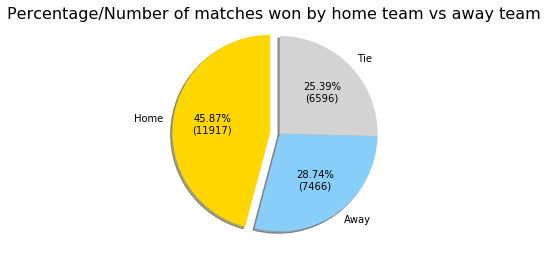

In [77]:
#create a pie chart to show the percentage and number of matches won vs matches lost and drawn at home location
labels = 'Home', 'Away', 'Tie'
colors = ['gold', 'lightskyblue', 'lightgrey']
explode = (0.1, 0.0, 0.0)  # only "explode" the 1st slice (i.e. 'Won')

fig1, ax1 = plt.subplots()
ax1.pie(result,explode=explode,labels=labels,autopct=lambda p:'{:.2f}%''\n({:.0f})'.format(p,(p/100)*result.sum()),colors=colors,shadow=True,startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage/Number of matches won by home team vs away team', fontsize = 16)
plt.show()

The above pie chart suggests that home teams have won 46 percent of matches played while away teams have won only 29 percent of matches played. 25 percent of matches resulted in a draw. 

From this we can infer that playing at home increases the chances of a team to win a match. 

In [78]:
# groupby home_outcome (draw, lost, won) and display the mean of home team goals scored 
score_home = df_match.groupby('home_outcome').mean()['home_team_goal']
score_home

home_outcome
d    0.993026
l    0.596169
w    2.444071
Name: home_team_goal, dtype: float64

In [79]:
# groupby away_outcome (draw, lost, won) and display the mean of away team goals scored 
score_away = df_match.groupby('away_outcome').mean()['away_team_goal']
score_away

away_outcome
d    0.993026
l    0.539901
w    2.300563
Name: away_team_goal, dtype: float64

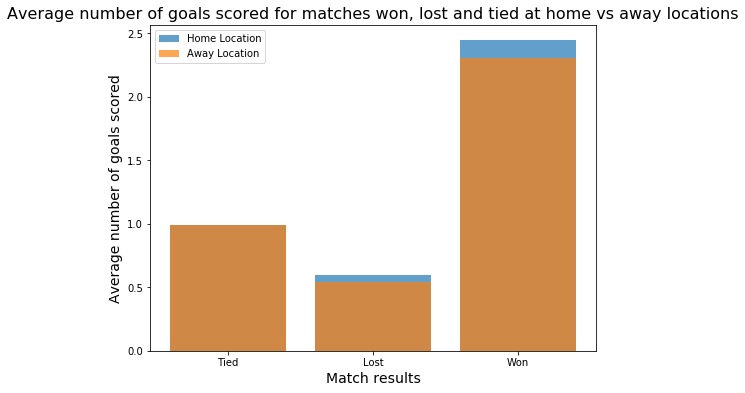

In [80]:
#create a double bar graph showing the average number of goals scored for 
# matches won, lost and tied at home and away locations
n_groups = 3
fig, ax = plt.subplots(figsize = (8,6))
index = np.arange(n_groups)
plt.bar(score_home.index, score_home,align='center', alpha=0.7,label='Home Location')
plt.bar(score_away.index, score_away,align='center', alpha=0.7,label='Away Location')
plt.title("Average number of goals scored for matches won, lost and tied at home vs away locations", fontsize = 16)
plt.xlabel("Match results", fontsize = 14)
plt.ylabel("Average number of goals scored", fontsize = 14)
plt.xticks(index,('Tied', 'Lost', 'Won'))
plt.legend()
plt.show();

From the above bar graph we can deduce the following:                                                                       
a) Home teams have won matches scoring an average of 2.44 goals per match whereas the away teams have won matches scoring an average of 2.30 goals per match.                                                                                         
b) Home teams have lost matches scoring an average of 0.60 goals per match whereas the away teams have lost matches scoring an average of 0.54 goals per match.                                                                                         

This shows that win or lose, home teams score more goals than away teams on an average.

In [81]:
# Find out the number of teams who have scored better when at home?

# groupby home_team_api_id and find the average number of goals scored by each home team 
df_goals_home = df_match.groupby(['home_team_api_id']).mean()['home_team_goal']
df_goals_home.head(1)

home_team_api_id
1601    1.233333
Name: home_team_goal, dtype: float64

In [82]:
# groupby away_team_api_id and find the average number of goals scored by each away team 
df_goals_away = df_match.groupby(['away_team_api_id']).mean()['away_team_goal']
df_goals_away.head(1)

away_team_api_id
1601    1.1
Name: away_team_goal, dtype: float64

In [83]:
# merge/concatenate (using inner join) the df_goals_home and df_goals_away into df_data dataframe 
df_data = pd.concat([df_goals_home,df_goals_away], join='inner',axis =1)
df_data.head(1)

,home_team_goal,away_team_goal
1601,1.233333,1.1


In [84]:
# add a 'team_scored_higher' column into df_data based on average number of home_team_goal vs 
# average number of away_team_goal
df_data['higher_score_at_home'] = df_data.apply(lambda x: 'yes' if(x.home_team_goal > x.away_team_goal) else ('no' if(x.home_team_goal < x.away_team_goal) else 'draw'), axis = 1)
df_data.head(1)

,home_team_goal,away_team_goal,higher_score_at_home
1601,1.233333,1.1,yes


In [85]:
# Groups the number of teams that have on an avaergae won, lost and drawn at home locations
result = df_data.higher_score_at_home.value_counts()
result

yes     286
no        9
draw      4
Name: higher_score_at_home, dtype: int64

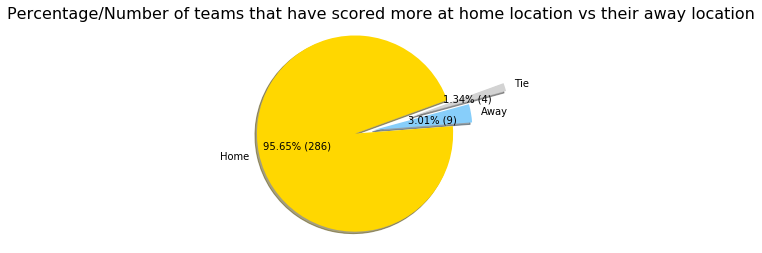

In [86]:
# create a pie chart to show the percentage/number of teams that have scored 
# more at home location vs their away location
labels = 'Home', 'Away', 'Tie'
colors = ['gold', 'lightskyblue', 'lightgrey']
explode = (0.1, 0.1, 0.5)  # "explode" all slices so that the data is visible

fig1, ax1 = plt.subplots()
ax1.pie(result,explode=explode,labels=labels,autopct=lambda p:'{:.2f}%'' ({:.0f})'.format(p,(p/100)*result.sum()),colors=colors,shadow=True,startangle=20)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage/Number of teams that have scored more at home location vs their away location', fontsize=16)
plt.show();

The above pie chart depicts that out of 299 teams, 96% of teams have scored higher at home location in comparison to their away location. Only about 3% of teams have scored higher at an away location than at home location and about 1% of teams have scored about the same whether at home or away location.

From this we can infer that more teams are likely to score higher number of goals on an average while playing at home location when compared to away location. 

#### The below code will help analyze which teams have scored max/min home goals? 

In [87]:
# create a new column 'match_team_api_id' with values from indexes of each row of df_data dataframe.
df_data['match_team_api_id'] = df_data.index 
df_data.head(1)

,home_team_goal,away_team_goal,higher_score_at_home,match_team_api_id
1601,1.233333,1.1,yes,1601


In [88]:
#Merging the df_data dataframe with df_team dataframe. 
df_team_match_combined = df_data.merge(df_team, left_on='match_team_api_id',right_on='team_api_id',how='inner')
df_team_match_combined.head(1)

,home_team_goal,away_team_goal,higher_score_at_home,match_team_api_id,id,team_api_id,team_long_name,team_short_name
0,1.233333,1.1,yes,1601,31446,1601,Ruch Chorzów,CHO


In [89]:
# Find team which has scored max home goals (mean). 
max_home_goal = df_team_match_combined.home_team_goal.max()
df_team_match_combined.query('home_team_goal == {}'.format(max_home_goal))

,home_team_goal,away_team_goal,higher_score_at_home,match_team_api_id,id,team_api_id,team_long_name,team_short_name
140,3.322368,2.223684,yes,8633,43040,8633,Real Madrid CF,REA


Real Madrid CF (REA) has scored max number of home goals (mean). On an average Real Madrid CF (REA) has scored 3.32 goals.

In [90]:
# Find team which has scored min home goals (mean).
min_home_goal = df_team_match_combined.home_team_goal.min()
df_team_match_combined.query('home_team_goal == {}'.format(min_home_goal))

,home_team_goal,away_team_goal,higher_score_at_home,match_team_api_id,id,team_api_id,team_long_name,team_short_name
76,0.588235,0.941176,no,8357,18079,8357,SpVgg Greuther Fürth,GRF


SpVgg Greuther Fürth (GRF) has scored min number of home goals (mean). On an average SpVgg Greuther Fürth (GRF) has scored only 0.59 goals.

#### The below code will help analyze which teams have scored max/min away goals? 

In [91]:
# Find team which has scored max away goals (mean).
max_away_goal = df_team_match_combined.away_team_goal.max()
df_team_match_combined.query('away_team_goal == {}'.format(max_away_goal))

,home_team_goal,away_team_goal,higher_score_at_home,match_team_api_id,id,team_api_id,team_long_name,team_short_name
141,3.256579,2.328947,yes,8634,43042,8634,FC Barcelona,BAR


FC Barcelona (BAR) has scored max number of away goals (mean). On an average FC Barcelona (BAR) has scored 2.33 goals.

In [92]:
min_away_goal = df_team_match_combined.away_team_goal.min()
df_team_match_combined.query('away_team_goal == {}'.format(min_away_goal))

,home_team_goal,away_team_goal,higher_score_at_home,match_team_api_id,id,team_api_id,team_long_name,team_short_name
116,1.368421,0.263158,yes,8550,14106,8550,FC Metz,MET


FC Metz (MET) has scored min number of away goals (mean). On an average FC Metz (MET) has scored only 0.26 goals.

### Research Question 2 : Which teams have changed its performance most over time and which teams have changed its performance least over time?

In [93]:
# Copying all the rows from df_match dataset whose home_outcome is w (won) into df_home_wins dataset
df_home_wins = df_match.query('home_outcome == "w"')
df_home_wins.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_outcome,away_outcome
3,4,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0,w,l


In [94]:
# Moving only selected columns into the dataset. Also renaming some columns in the dataset for uniformity
df_home_wins = df_home_wins[['id','country_id','league_id','season','stage','date','match_api_id','home_team_api_id','home_outcome']]
df_home_wins.rename(columns={'home_team_api_id':'team_api_id','home_outcome':'outcome'},inplace=True)

In [95]:
# display df_home_wins dataset.
df_home_wins.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,team_api_id,outcome
3,4,1,1,2008/2009,1,2008-08-17,492476,9991,w


In [96]:
# Copying all the rows from df_match dataset whose away_outcome is w (won) into df_away_wins dataset
df_away_wins = df_match.query('away_outcome == "w"')
df_away_wins.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_outcome,away_outcome
2,3,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3,l,w


In [97]:
# Moving only selected columns into the dataset. Also renaming some columns in the dataset for uniformity
df_away_wins = df_away_wins[['id','country_id','league_id','season','stage','date','match_api_id','away_team_api_id','away_outcome']]
df_away_wins.rename(columns={'away_team_api_id':'team_api_id','away_outcome':'outcome'},inplace=True)

In [98]:
# display df_away_wins dataset.
df_away_wins.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,team_api_id,outcome
2,3,1,1,2008/2009,1,2008-08-16,492475,8635,w


In [99]:
# merge the df_home_wins and df_away_wins dataset
df_wins_combined = pd.concat([df_home_wins,df_away_wins])
df_wins_combined.head()

,id,country_id,league_id,season,stage,date,match_api_id,team_api_id,outcome
3,4,1,1,2008/2009,1,2008-08-17,492476,9991,w
8,9,1,1,2008/2009,1,2008-08-16,492481,10001,w
9,10,1,1,2008/2009,10,2008-11-01,492564,8342,w
21,22,1,1,2008/2009,11,2008-11-07,492576,9984,w
25,26,1,1,2008/2009,11,2008-11-08,492580,10001,w


In [100]:
# Using the df_wins_combined dataset groupby season and team_api_id and count the number of entries
df_team_season_count = df_wins_combined.groupby(['season','team_api_id']).outcome.count().reset_index()
df_team_season_count.head()

,season,team_api_id,outcome
0,2008/2009,1601,9
1,2008/2009,1957,9
2,2008/2009,2182,16
3,2008/2009,2183,15
4,2008/2009,2186,7


In [101]:
# Using the dataset grouped by season and team id (df_team_season_count), 
# further groupby team_api_id and fetch the max and min wins for each team across different season
df_team_count = df_team_season_count.groupby(['team_api_id'])['outcome'].agg({'max','min'}).reset_index()
df_team_count.head()

,team_api_id,max,min
0,1601,16,8
1,1773,8,7
2,1957,14,8
3,2033,9,5
4,2182,19,13


In [102]:
# Add a column called diff by subtracting min from max
df_team_count['diff'] = df_team_count['max'] - df_team_count['min']
df_team_count.head(2)

,team_api_id,max,min,diff
0,1601,16,8,8
1,1773,8,7,1


In [103]:
# Merging the df_team_count dataset with the df_team dataset.
df_team_match_combined = df_team_count.merge(df_team, left_on='team_api_id',right_on='team_api_id',how='inner')

In [104]:
# display the combined dataset
df_team_match_combined.head(1)

,team_api_id,max,min,diff,id,team_long_name,team_short_name
0,1601,16,8,8,31446,Ruch Chorzów,CHO


In [105]:
# Find the teams which has changed its performace most over time
max_diff = df_team_match_combined['diff'].max()
df_max_diff = df_team_match_combined.query('diff == {}'.format(max_diff))
df_max_diff.head()

,team_api_id,max,min,diff,id,team_long_name,team_short_name
202,9847,30,12,18,9548,Paris Saint-Germain,PSG
223,9885,33,15,18,20522,Juventus,JUV


The following teams have most change in its performance:                                                                   
a. Paris Saint-Germain (PSG) and                                                                                           
b. Juventus (JUV)                                                                                                                                                                                                                

In [106]:
# Find the teams which has changed its performace least over time
min_diff = df_team_match_combined['diff'].min()
df_min_diff = df_team_match_combined.query('diff == {}'.format(min_diff))
df_min_diff.head()

,team_api_id,max,min,diff,id,team_long_name,team_short_name
7,4049,7,7,0,15,Tubize,TUB
8,4064,5,5,0,36723,Feirense,FEI
10,4170,7,7,0,10312,US Boulogne Cote D'Opale,BOU
11,6269,6,6,0,22805,Novara,NOV
12,6351,5,5,0,1042,KAS Eupen,EUP


The following teams have least change in its performance:                                                                   
a. Tubize (TUB),                                                                                                           
b. Feirense (FEI),                                                                                                         
c. US Boulogne Cote D'Opale(BOU),                                                                                          
d. Novara (NOV) and                                                                                                        
e. KAS Eupen (EUP)                                                                                                         

### Research Question 3 : Which players has the most number of penalties?

In [107]:
# Dispaly a few records
df_player_att.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,penalties
0,1,218353,505942,2016-02-18,67.0,71.0,right,48
1,2,218353,505942,2015-11-19,67.0,71.0,right,48
2,3,218353,505942,2015-09-21,62.0,66.0,right,48
3,4,218353,505942,2015-03-20,61.0,65.0,right,47
4,5,218353,505942,2007-02-22,61.0,65.0,right,47


In [108]:
# groupby player_api_id and sum the number of penalties per player
df_penalties = df_player_att.groupby(['player_api_id'])['penalties'].sum().reset_index()
df_penalties.head(1)

,player_api_id,penalties
0,2625,867


In [109]:
#To get the player name, merger the df_penalties dataset with the df_player dataset.
df_penalties_cmb = df_penalties.merge(df_player, left_on='player_api_id', right_on='player_api_id',how='inner')
df_penalties_cmb.head(1)

,player_api_id,penalties,id,player_name,player_fifa_api_id,birthday,height,weight
0,2625,867,8372,"Patryk Rachwal,18",148544,1981-01-27 00:00:00,175.26,154


In [113]:
# Sort by penalties in desc order because we only need 10 players with top 10 most penalties
df_penalties_player = df_penalties_cmb.sort_values(by='penalties', ascending=False).head(10)
df_penalties_player.head(1)

,player_api_id,penalties,id,player_name,player_fifa_api_id,birthday,height,weight
4087,41269,4314,396,Alessio Cerci,178393,1987-07-23 00:00:00,180.34,172


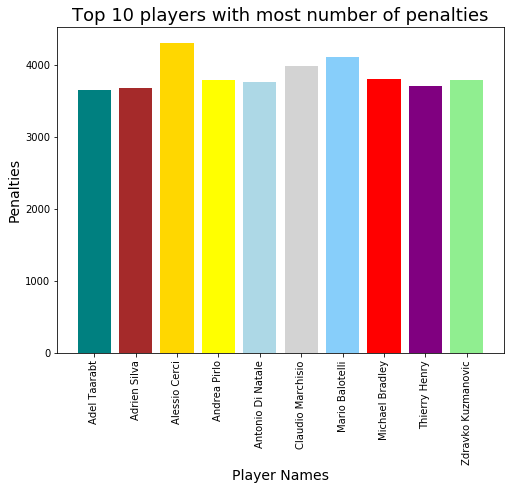

In [114]:
#create a bar graph showing the top 10 players with most number of penalties
fig, ax = plt.subplots(figsize = (8,6))
colors = ['gold','lightskyblue','lightgrey','red','lightgreen','yellow','lightblue','purple','brown','teal']
plt.bar(df_penalties_player['player_name'], df_penalties_player['penalties'],color=colors);
plt.title("Top 10 players with most number of penalties", fontsize=18)
plt.xlabel("Player Names", fontsize=14)
plt.ylabel("Penalties", fontsize=14)
plt.xticks(rotation=90)
plt.show();

The following players have the most number of penalties:
1.  Alessio Cerci (4314)
2.  Mario Balotelli (4120)
3.  Claudio Marchisio (3984)
4.  Michael Bradley (3813)
5.  Zdravko Kuzmanovic (3799)
6.  Andrea Pirlo (3791)
7.  Antonio Di Natale (3767)
8.  Thierry Henry (3712)
9.  Adrien Silva (3682)
10. Adel Taarabt (3650)

<a id='conclusions'></a>
## Conclusions

> Q1: a. Does home teams have an advantage over away teams?            
>> 1. Playing at home increases the chances of a team to win a match. 46% of home matches are won as compared to 29% of away matches.                                                                                                               
>> 2. Win or lose, home teams score more goals than away teams on an average.                                               
>> 3. More teams are likely to score higher number of goals on an average while playing at home location when compared to away location. 96% of teams out of 299 teams have scored higher at home location in comparison to their away scores. Only about 3% of teams have scored higher at an away location than at home location. 

> Q1: b. And which teams have scored max/min home and away goals?
>> 1. Real Madrid CF (REA) has scored max number of home goals whereas FC Barcelona (BAR) has scored max number of away goals.                                                                                                                     
>> 2. SpVgg Greuther Fürth (GRF) has scored min number of home goals whereas FC Metz (MET) has scored min number of away goals.

> Q2: Which teams have changed its performance most over time and which teams have changed its performance least over time? 
>> 1. The following teams have most change in its performance:                                                             
>>>a. Paris Saint-Germain (PSG) and                                                                                         
>>>b. Juventus (JUV)                                                                                                       
>>2. The following teams have least change in its performance:                                                             
>>>a. Tubize (TUB),                                                                                                         
>>>b. Feirense (FEI),                                                                                                       
>>>c. US Boulogne Cote D'Opale(BOU),                                                                                       
>>>d. Novara (NOV) and                                                                                                     
>>>e. KAS Eupen (EUP)                                                                                                       

> Q3: Which players has the most number of penalties? 
>>The following players have the most number of penalties:                                                             
>>>1.  Alessio Cerci (4314)
>>>2.  Mario Balotelli (4120)
>>>3.  Claudio Marchisio (3984)
>>>4.  Michael Bradley (3813)
>>>5.  Zdravko Kuzmanovic (3799)
>>>6.  Andrea Pirlo (3791)
>>>7.  Antonio Di Natale (3767)
>>>8.  Thierry Henry (3712)
>>>9.  Adrien Silva (3682)
>>>10. Adel Taarabt (3650)


##### Limitations
>> I have not used statistics for any data analysis performed here.                                                         
>> The Kaggle dataset may not be accurate. We may have more home matches that were won than away matches in the dataset skewing our results one way.                                                                                               
>> The max/min number of avg goals scored by teams may not be accurate. The max number of goals were calculated using mean. The mean can be effected by presence of outliers in dataset (some teams may have scored exceptionally high goals in some matches).                                                                                                                  
>> The number of penalties per player may not be accurate. We may have more data for some players when compared to the others in the kaggle dataset. The most penlities scored is based on the sum of penalties for each player and not mean.     

##### References
<ul>
<li><a href="https://www.tutorialspoint.com/python_pandas/python_pandas_sorting.htm">Python Panda - Sorting</a></li>
<li><a href="https://datatofish.com/bar-chart-python-matplotlib/">How to create bar charts</a></li>
<li><a href="https://365datascience.com/bar-chart-python-matplotlib/">Bar chart in Matplotlib - Python</a></li>
<li><a href="https://www.geeksforgeeks.org/convert-floats-to-integers-in-a-pandas-dataframe/">Convert in Panda</a></li>
<li><a href="https://www.opentechguides.com/how-to/article/dataanalytics/179/jupyter-notebook-pandas.html">Data Visualization</a></li>
<li><a href="https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe">Select multiple columns in dataframe</a></li>
<li><a href="https://www.geeksforgeeks.org/how-to-convert-index-to-column-in-pandas-dataframe/">Index to column</a></li>
<li><a href="https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct">Matplotlib Autopct</a></li>
<li><a href="https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html">Basic Pie Chart</a></li>
<li><a href="https://stackoverflow.com/questions/61634759/python-futurewarning-indexing-with-multiple-keys-implicitly-converted-to-a-tup?noredirect=1&lq=1">Indexing with multiple key error</a></li>
<li><a href="https://stackoverflow.com/questions/39922986/pandas-group-by-and-sum">Gorupby and sum</a></li>
<li><a href="https://pythonspot.com/sqlite-database-with-pandas/">Sqlite database with pandas</a></li>
</ul>

## Submitting your Project 


In [115]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0